In [ ]:
# default_exp core

# Module core

> Nipype and mrtrix3 based pre-/post- processing pipeline for brain diffusion-MRI and generation of structural connectomes of the brain. This module contains customized and up-to-date command line interfaces that are not found from Nipype's interfaces module.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%%capture
#export
import os, sys
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, File
from nipype.interfaces.base import TraitedSpec, traits
from nipype.interfaces.io import BIDSDataGrabber
from bids.layout import BIDSLayout

import nibabel as nb
from nilearn import plotting
from nilearn.image import new_img_like

from nipype.interfaces import fsl
from nipype.interfaces.freesurfer.preprocess import ReconAll

Environment testing:

In [ ]:
#test
# if our sample data can create BIDS layouts
data_dir = "/Users/xxie/sample_data/BIDS_output/"

## test datasets first:
data1 = os.path.join(data_dir)
# data2 = os.path.join(data_dir, 'healthy_control/')

layout = BIDSLayout(data1)
assert len(layout.get_subjects()) != 0
assert type(layout.get_subjects() is list)

# layout = BIDSLayout(data2)
# assert len(layout.get_subjects()) != 0
# assert type(layout.get_subjects() is list)

### BIDS Data Input

Get subjects from BIDS directory:

In [ ]:
#export
def get_subs(sub_dir="data"):
    """
    Gets list of subjects in a BIDS directory, by default it looks in "data" folder in your CWD
    Input str of path to BIDS dir otherwise
    """
    print(
        "Creating layout of data directory, might take a while if there are a lot of subjects"
    )
    layout = BIDSLayout(sub_dir)
    sub_list = layout.get_subjects()
    return sub_list, layout

In [ ]:
#example usage:
sub_list, layout = get_subs(data_dir)
print(sub_list)

Creating layout of data directory, might take a while if there are a lot of subjects
['01']


In [ ]:
#test
import glob
#if subjects were all grabbed
assert len(get_subs(data_dir)[0]) == len(glob.glob(data_dir+ '/sub-*'))

Creating layout of data directory, might take a while if there are a lot of subjects


Find FSL `.bval/.bvec` gradient file paths:

In [ ]:
# export
def get_bfiles_tuple(in_List):
    """
    read .bvec and .bval files in as a list and spit out tuple for nipype input
    """
    # bvs = layout.get(subject = sub_list[0], suffix = 'dwi', session = 1, extensions = ['bvec', 'bval'], return_type = 'file')
    bvs_tuple = tuple(in_List)[::-1]
    return bvs_tuple

In [ ]:
#example usage:
bfiles = layout.get(
    subject=sub_list[0],
    suffix="dwi",
    session='002',
    extensions=["bvec", "bval"],
    return_type="file",
) # here we are using session 002 as an example input
print(bfiles)
bfiles_fsl = get_bfiles_tuple(bfiles)
print(bfiles_fsl)

['/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bval', '/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bvec']
('/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bvec', '/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bval')


In [ ]:
#test
#if bfiles are grabbed
assert len(get_bfiles_tuple(bfiles)) == 2

Get dwi images:

In [ ]:
#example usage
dwi = layout.get(
    subject=sub_list[0],
    datatype="dwi",
    extensions=[".nii", ".nii.gz"],
    return_type="file",
)

In [ ]:
#test
#if all sessions are grabbed
assert len(dwi) == len(layout.get_sessions())

Get anatomical images:

In [ ]:
#example usage
anat = layout.get(
    subject=sub_list[0],
    datatype = 'anat',
    session='002',
    extensions=[".nii", ".nii.gz"],
    return_type="filename",
)
print(anat)

['/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/anat/sub-01_ses-002_T1w.nii.gz']


#### ACPC MNI alignment (HCP Based), as seen on brainlife.io: 

This realigns our cropped anatomical image inputs to the MNI template using HCP pipeline procedure with FSL's `aff2rigid`. We want to do everything in MNI space.

In [ ]:
#export
class aff2rigidInputSpec(CommandLineInputSpec):
    """
    Specifying inputs to fsl's aff2rigid
    """
    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=1, desc="FLIRT transform (12 DOF) from the input image to standard"
    )
    out_file = File(
        manndatory=True, argstr="%s", position=2, desc="output matrix which will go from the input image to standard space (6 DOF)"
    )
    
class aff2rigidOutputSpec(TraitedSpec):
    """
    Specifying outputs of aff2rigid
    """
    out_file = File(argstr="%s", desc="output matrix")
    
class fslaff2rigid(CommandLine):
    """
    Align cropped image the ACPC plane using FSL's aff2rigid
    """
    _cmd = "aff2rigid"
    input_spec = aff2rigidInputSpec
    output_spec = aff2rigidOutputSpec
    
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs 

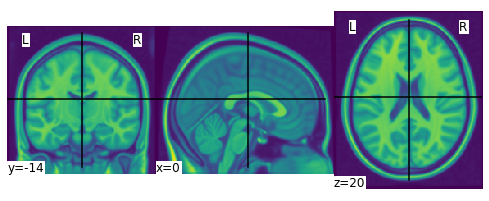

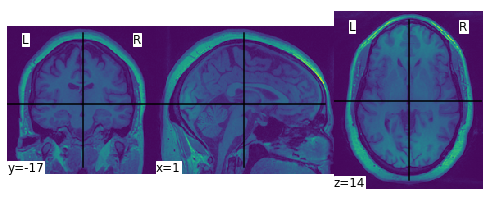

In [ ]:
#example
#usage:

rfov = fsl.utils.RobustFOV() # first reduce FOV of T1 image
rfov.inputs.in_file = anat[0]
rfov.inputs.out_transform = 'outputs/roi2full.mat'
rfov.inputs.out_roi = 'outputs/robustfov.nii.gz'
rfov.run() # run RobustFOV

inv_xfm = fsl.utils.ConvertXFM() # inverse transformation matrix
inv_xfm.inputs.in_file = 'outputs/roi2full.mat'
inv_xfm.inputs.invert_xfm = True
inv_xfm.inputs.out_file = 'outputs/full2roi.mat'
inv_xfm.run() 

temp_ref = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz')
flirt = fsl.preprocess.FLIRT()
flirt.inputs.in_file = 'outputs/robustfov.nii.gz'
flirt.inputs.reference = temp_ref
flirt.inputs.interp = 'spline'
flirt.inputs.out_matrix_file = 'outputs/roi2std.mat' 
flirt.inputs.out_file = 'outputs/acpc_mni.nii.gz'
flirt.run() # align acpc mni

concat = fsl.utils.ConvertXFM() # concatenate xfm
concat.inputs.in_file2 = 'outputs/roi2std.mat'
concat.inputs.in_file = 'outputs/full2roi.mat'
concat.inputs.concat_xfm = True
concat.inputs.out_file = 'outputs/full2std.mat'
concat.run()

affr = fslaff2rigid()
affr.inputs.in_file = 'outputs/full2std.mat'
affr.inputs.out_file = 'outputs/outputmatrix.mat'
affr.run()

warp = fsl.preprocess.ApplyWarp() # apply warp finally
warp.inputs.in_file = anat[0]
warp.inputs.relwarp = True
warp.inputs.interp = 'spline'
warp.inputs.ref_file = temp_ref
warp.inputs.out_file = 'outputs/acpc_t1.nii.gz'
warp.inputs.premat = 'outputs/outputmatrix.mat'
warp.run()

# if we visualize both the MNI template and aligned T1, they should be in the same coordinate system
template_img = nb.load(temp_ref)
template_data = template_img.get_fdata()
img = new_img_like(template_img, template_data, affine=template_img.affine, copy_header=True)
_ = plotting.plot_img(img)

acpc_img = nb.load('outputs/acpc_t1.nii.gz')
acpc_data = acpc_img.get_fdata()
t1_img = new_img_like(acpc_img, acpc_data, affine=acpc_img.affine, copy_header=True)
_ = plotting.plot_img(t1_img)

### Freesurfer `recon-all` for the ACPC-aligned image:

In [ ]:
reconall = ReconAll()
reconall.inputs.directive = 'all'
reconall.inputs.T1_files = 'outputs/acpc_t1.nii'
#reconall.inputs.subject_id = 'sub-'+sub_list[0]
reconall.inputs.subjects_dir = 'outputs/freesurfer'
reconall.inputs.hippocampal_subfields_T1 = True
reconall.inputs.parallel = True
reconall.inputs.openmp = 6
reconall.cmdline
reconall.run()

#### Check gradient orientations and create corrected image:

#### Denoise DWI:

In [ ]:
#export
class dwidenoiseInputSpec(CommandLineInputSpec):
    """
    Specifying inputs to dwidenoise
    """

    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=1, desc="input image"
    )
    noise = File(
        mandatory=True, argstr="-noise %s", position=2, desc="output noise map"
    )
    out_file = File(
        mandatory=True, argstr="%s", position=-1, desc="output denoised image"
    )
    quiet = traits.Str(argstr="%s", position=3, desc="suppress verbose outputs")
    force = traits.Str(
        argstr="%s", position=4, desc="force output file if the file already exits"
    )
    nthreads = traits.Int(
        argstr="-nthreads %d", position=5, desc="use this number of threads"
    )


class dwidenoiseOutputSpec(TraitedSpec):
    """
    Specifying outputs of dwidenoise
    """

    noise = File(argstr="%s", desc="output noise level map")
    out_file = File(argstr="%s", desc="output denoised file")


class dwidenoise(CommandLine):
    """
    Denoise DWI data with mrtrix3's dwidenoise.
    This should be performed as the first step of the preprocessing pipeline!
    Arguments:
        in_file (str): Input DWI image
        noise (str): output noise map
        out_file (str): output denoised image
        quiet (str): whether we should suppress output
        force (str): replace existing image (overwrite past runs outputs)
        nthreads (int): number of threads to use
    """

    _cmd = "dwidenoise"
    input_spec = dwidenoiseInputSpec
    output_spec = dwidenoiseOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["noise"] = os.path.abspath(self.inputs.noise)
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#example
#usage:

denoise = dwidenoise()
denoise.inputs.out_file = "outputs/denoised.nii.gz"
denoise.inputs.noise = "outputs/noise.nii.gz"
denoise.inputs.in_file = dwi[0]  # the first session's image
denoise.inputs.force = "-force"
denoise.run()

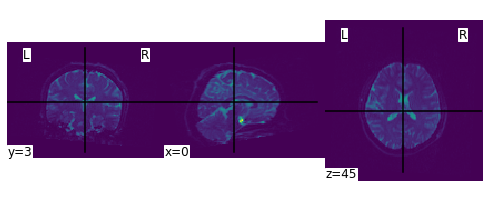

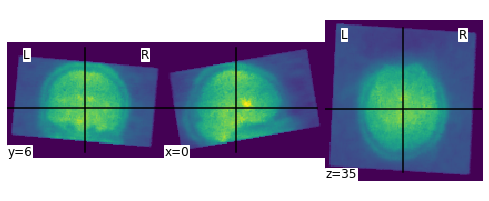

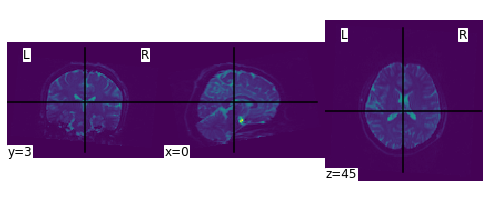

In [ ]:
#example
#visualize:
orig_dwi = nb.load(dwi[0])  # display dwi
orig_data = orig_dwi.get_fdata()[:, :, :, 0]
orig_img = new_img_like(orig_dwi, orig_data, affine=orig_dwi.affine, copy_header=True)
_ = plotting.plot_img(orig_img)

_ = plotting.plot_img(denoise.inputs.noise)

denoised_dwi = nb.load(denoise.inputs.out_file)
denoised_data = denoised_dwi.get_fdata()[:, :, :, 0]
denoised_img = new_img_like(
    denoised_dwi, denoised_data, affine=denoised_dwi.affine, copy_header=True
)
_ = plotting.plot_img(denoised_img)

In [ ]:
# # test if denoised file exists
#from fastcore.test import *
#
#test_eq(os.path.exists(denoise.inputs.noise), True)
#test_eq(os.path.exists(denoise.inputs.out_file), True)

Bias field correction:

In [ ]:
# export
class N4BiasFieldCorrectionInputSpec(CommandLineInputSpec):
    """
    Input specifications
    """

    in_file = File(
        exists=True,
        mandatory=True,
        argstr="-i %s",
        position=1,
        desc="input denoised file",
    )
    dims = traits.Int(
        mandatory=True, argstr="-d %d", position=0, desc="dimension of input image"
    )
    out_file = File(mandatory=True, argstr="-o %s", position=2, desc="the output image")


class N4BiasFieldCorrectionOutputSpec(TraitedSpec):
    """
    Output specifications
    """

    out_file = File(desc="output denoised and bias corrected file")


class N4BiasFieldCorrection(CommandLine):
    """
    ANTs Bias field correction.
    Arguments:
        in_file (str) = input file, for the pipeline, connect the denoised dwi file here
        dims (int)    = input volume dimensions, for dwi's the value is 4
        outfile (str) = name of output file, for pipeline, connect this to datasink and next step
    Returns:
        out_file (str) = .nii.gz file output, bias field corrected image
    """

    _cmd = "N4BiasFieldCorrection"
    input_spec = N4BiasFieldCorrectionInputSpec
    output_spec = N4BiasFieldCorrectionOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        # Get the attribute saved during _run_interface
        return outputs

In [ ]:
#example
#usage
ants_bfc = N4BiasFieldCorrection()
ants_bfc.inputs.out_file = 'outputs/biasfieldcorrected.nii.gz'
ants_bfc.inputs.dims = 4
ants_bfc.inputs.in_file = 'outputs/denoised.nii.gz'
ants_bfc.run()

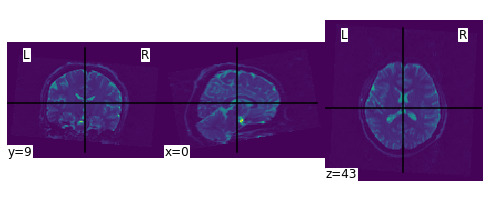

In [ ]:
#example
#visualize
corrected_dwi = nb.load('outputs/biasfieldcorrected.nii.gz')
corrected_data = corrected_dwi.get_fdata()[:, :, :, 0]  # first b0 volume
correctedb0_img = new_img_like(
    corrected_dwi, corrected_data, affine=corrected_dwi.affine, copy_header=True
)
_ = plotting.plot_img(correctedb0_img)

In [ ]:
# # test if file output is correct
#test_eq(os.path.exists('outputs/biasfieldcorrected.nii.gz'), True)

Motion and eddy current correction

In [ ]:
# export
class dwipreprocInputSpec(CommandLineInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        position=0,
        desc="input denoised, corrected file",
    )
    rpe_options = traits.Str(
        mandatory=True,
        argstr="%s",
        position=2,
        desc="acquisition phase-encoding design",
    )
    pe_dir = traits.Str(
        mandatory=True, argstr="-pe_dir %s", position=3, desc="phase encoding direction"
    )
    eddy_options = traits.Str(
        mandatory=False,
        argstr="-eddy_options %s",
        position=4,
        desc="eddy command options within quotation marks and contains at least one space",
    )
    nthreads = traits.Int(
        mandatory=False,
        argstr="-nthreads %d",
        position=5,
        desc="number of available CPUs to use, no input means all available CPUs",
    )
    grad_fsl = traits.Tuple(
        (traits.Str, traits.Str),
        mandatory=True,
        argstr="-fslgrad %s %s",
        position=6,
        desc="provide gradient table in fsl format",
    )
    out_file = File(
        mandatory=True,
        argstr="%s",
        position=1,
        desc="output denoised, corrected, preproc image",
    )


class dwipreprocOutputSpec(TraitedSpec):
    out_file = File(argstr="%s", desc="output denoised, corrected, preproc image")


class dwipreproc(CommandLine):
    """
    mrtrix3 dwipreproc for motion/eddy current correction
    Arguments: 
        in_file (str): input file that needs the artifact correction
        rpe_options (str): phase-encoding design, see mrtrix3's dwipreproc for detail options
        pe_dir (str): phase encoding directions, see mrtrix3's dwipreproc for detail options
        eddy_options (str): eddy current correction options. see mrtrix3's dwipreproc for detail options
        nthreads (int): number of threads used
        grad_fsl (tuple): bvec/bval files
        out_file (str): file name and path for output
    Returns:
        out_file (str): preprocessed file, this is the input to tractography.
    """

    _cmd = "dwifslpreproc"
    input_spec = dwipreprocInputSpec
    output_spec = dwipreprocOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#example
#usage:
preproc = dwipreproc()
preproc.inputs.in_file = ants_bfc.inputs.out_file
preproc.inputs.rpe_options = "-rpe_none"
preproc.inputs.pe_dir = "j-"  # AP direction
preproc.inputs.eddy_options = '"--slm=linear "'
preproc.inputs.nthreads = 4
preproc.inputs.grad_fsl = bfiles_fsl
preproc.inputs.out_file = "outputs/preproc.nii.gz"
preproc.run()

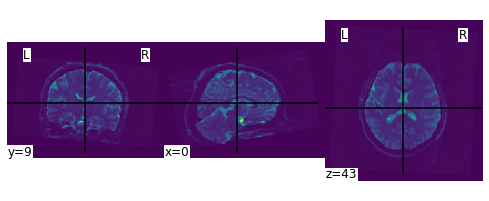

In [ ]:
#example
## visualize
preproc_dwi = nb.load("outputs/preproc.nii.gz")
preproc_data = preproc_dwi.get_fdata()[:, :, :, 0]  # first b0 volume
preproc_img = new_img_like(
    preproc_dwi, preproc_data, affine=preproc_dwi.affine, copy_header=True
)
_ = plotting.plot_img(preproc_img)

In [ ]:
# # test if image has been produced
#test_eq(os.path.exists("outputs/preproc.nii.gz"), True)

Brain extraction function input format:

In [ ]:
# export
def mask2seedtuple(mask_file, grid_size):
    seed_grid_tuple = (
        mask_file,
        grid_size,
    )
    return seed_grid_tuple